# Predicting & Explaining Textile Rejects (Zero-Inflated Continuous Loss)

## Project overview
In textile manufacturing, quality losses often appear as **rare events**: most production runs have **zero rejects**, but a small fraction can experience **non-negligible losses**. This notebook builds an applied, decision-oriented modeling pipeline to (1) **quantify risk**, (2) **explain drivers** of rejects, and (3) support **process improvement** using interpretable statistical models.

The goal is not only to “predict a number”, but to answer practical questions such as:
- **Which process levers** (controllable parameters) are most associated with rejects?
- **Which product/context factors** (non-controllable) explain risk differences across orders?
- Do **reject occurrence** and **reject severity** follow the same mechanism?

---

## Dataset
- Source: *Textile Knitting Dataset* (Kaggle)
- Unit of observation: a production record / order context (machine + fabric specs + shift context)
- Target (`Y`): **Reject Qty** (kg), a **zero-heavy** continuous variable

---

## Problem framing & modeling choice
`Reject Qty` is:
- **continuous** (kg), not a count
- **highly imbalanced** (many zeros)
- **heavy-tailed** when nonzero

This motivates probabilistic models designed for non-normal outcomes. In particular:
- GLM baselines (Poisson / NegBin / Gamma) are used as *comparisons*
- A **Tweedie GLM** is a principled option for *zeros + positive continuous losses*
- A **two-stage (hurdle) model** (Logistic + Gamma) separates:
  1) *whether a reject occurs* (`Y>0`)
  2) *how severe it is*, given it occurs (`Y | Y>0`)

This separation is especially useful in industrial settings because “prevention” and “damage containment” can require different interventions.

---

## Key takeaway
Even when extreme losses are difficult to forecast precisely, probabilistic modeling can still be highly valuable for **risk identification** and **actionable process insights**—which is often the primary business need in quality engineering.

# 1. Preliminary analysis

This section focuses on:
- Understanding the distribution and meaning of the target variable (`Reject Qty`)
- Verifying whether missing values represent true zeros or unrecorded information
- Identifying redundant or derived fields that should not enter the model directly

## 1.1 Import dataset

In [ ]:
import sys
print(sys.executable)

In [ ]:
import os
os.environ["KAGGLEHUB_CACHE"] = os.path.abspath("./.kagglehub_cache")
print("Using cache:", os.environ["KAGGLEHUB_CACHE"])

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("toufique33/textile-knitting-dataset")

print("Path to dataset files:", path)

In [4]:
print(os.listdir(path)[:50])

['knitting_dataset.csv']


In [ ]:
import pandas as pd

csv_path = os.path.join(path, "knitting_dataset.csv")
df = pd.read_csv(csv_path, encoding="cp1252")
df.head()

,M/C Brand,Production Date,M/C Dia & Gauge,Booking Type,Lot,Color,Color Range,stitch,Dia,GSM,...,yarn_count_tex_1,yarn_count_tex_2,yarn_count_tex_3,stitch_1,stitch_2,stitch_3,tightness_factor,composition,construction,body_part
0,Fukuhara,01-06-2022,52 X 14,Main,MGF-SS-8,PURE WHITE 00010,White Color,4.75,52,700,...,24.608333,NaN,NaN,4.75,NaN,NaN,1.044353,Cotton,Rib,Rib
1,Fukuhara,01-06-2022,52 X 14,Main,MGF-SS-8,PURE WHITE 00010,White Color,4.75,52,700,...,24.608333,NaN,NaN,4.75,NaN,NaN,1.044353,Cotton,Rib,Rib
2,Fukuhara,01-06-2022,52 X 14,Main,MGF-63,CHARCOAL HEATHER - 00009,Wash,4.75,52,700,...,24.608333,NaN,NaN,4.75,NaN,NaN,1.044353,Cotton,Rib,Rib
3,Fukuhara,01-06-2022,52 X 14,Main,"BF-22-10200,BF-22-12463",RIBBON RED[19-1663 TCX]; 5MM TIPPING-WHITE,Wash,4.70,52,700,...,24.608333,NaN,NaN,4.70,NaN,NaN,1.055464,Cotton,other,Rib
4,Fukuhara,01-06-2022,52 X 14,Main,BF-22-12463,RIBBON RED[19-1663 TCX]; 5MM TIPPING-WHITE,Wash,4.70,52,700,...,24.608333,NaN,NaN,4.70,NaN,NaN,1.055464,Cotton,other,Rib


In [21]:
print("Rows, Cols:", df.shape)

Rows, Cols: (12569, 38)


In [15]:
summary = pd.DataFrame({
    "dtype": df.dtypes,
    "nulls": df.isna().sum(),
    "null_%": (df.isna().mean() * 100).round(2),
    "unique": df.nunique(dropna=True),
}).sort_values(["nulls", "unique"], ascending=[False, True])

summary

,dtype,nulls,null_%,unique
yarn_count_tex_3,float64,11615,92.41,14
stitch_3,float64,11423,90.88,30
yarn_count_tex_2,float64,7697,61.24,22
stitch_2,float64,6521,51.88,103
Reject Qty,str,4448,35.39,112
Machine Total,float64,359,2.86,4740
Without Shift(Outbound),float64,52,0.41,1
Lot,str,36,0.29,1883
Booking Type,str,0,0.00,5
Yarn_count_length,int64,0,0.00,5


## 1.2 Remove duplicates

In [16]:
print("Duplicate rows:", df.duplicated().sum())

Duplicate rows: 6


In [20]:
dups = df[df.duplicated(keep=False)]
dups

,M/C Brand,Production Date,M/C Dia & Gauge,Booking Type,Lot,Color,Color Range,stitch,Dia,GSM,...,yarn_count_tex_1,yarn_count_tex_2,yarn_count_tex_3,stitch_1,stitch_2,stitch_3,tightness_factor,composition,construction,body_part
552,Pailung,05-06-2022,34 X 24,Main,PU-E887/M00W,PUMA WHITE-01,White Color,12.00/13.00,70,140,...,8.333333,NaN,NaN,12.00,13.0,NaN,0.240563,Polyester,Mesh,Top
555,Pailung,05-06-2022,34 X 24,Main,PU-E887/M00W,PUMA WHITE-01,White Color,12.00/13.00,70,140,...,8.333333,NaN,NaN,12.00,13.0,NaN,0.240563,Polyester,Mesh,Top
1333,Pailung,11-06-2022,34 X 24,Main,PU-E887/MJ0W,PUMA WHITE-01,White Color,12.00/13.00,70,140,...,8.333333,NaN,NaN,12.00,13.0,NaN,0.240563,Polyester,Mesh,Top
1353,Pailung,11-06-2022,34 X 24,Main,PU-E887/MJ0W,PUMA WHITE-01,White Color,12.00/13.00,70,140,...,8.333333,NaN,NaN,12.00,13.0,NaN,0.240563,Polyester,Mesh,Top
2403,Pailung,18-06-2022,34 X 24,Main,PU-E887/M00W,PUMA WHITE-01,White Color,12.00/13.00,70,140,...,8.333333,NaN,NaN,12.00,13.0,NaN,0.240563,Polyester,Mesh,Top
2405,Pailung,18-06-2022,34 X 24,Main,PU-E887/M00W,PUMA WHITE-01,White Color,12.00/13.00,70,140,...,8.333333,NaN,NaN,12.00,13.0,NaN,0.240563,Polyester,Mesh,Top
3048,Pailung,22-06-2022,34 X 24,Main,PU-E887/M00W,PUMA WHITE-01,White Color,12.00/13.00,70,140,...,8.333333,NaN,NaN,12.00,13.0,NaN,0.240563,Polyester,Mesh,Top
3050,Pailung,22-06-2022,34 X 24,Main,PU-E887/M00W,PUMA WHITE-01,White Color,12.00/13.00,70,140,...,8.333333,NaN,NaN,12.00,13.0,NaN,0.240563,Polyester,Mesh,Top
9025,Hangxing,07-08-2022,36 X 24,Main,PU-Y23004WQ,MEDIUM GRAY HEATHER-01,Melange,2.85,74,160,...,21.092857,NaN,NaN,2.85,NaN,NaN,1.611472,Cotton,S/J,Top
9048,Hangxing,07-08-2022,36 X 24,Main,PU-Y23004WQ,MEDIUM GRAY HEATHER-01,Melange,2.85,74,160,...,21.092857,NaN,NaN,2.85,NaN,NaN,1.611472,Cotton,S/J,Top


In [22]:
before = len(df)
df = df.drop_duplicates(keep="first").reset_index(drop=True)
after = len(df)

print("Removed:", before - after)
print("Now rows:", after)

Removed: 6
Now rows: 12563


## 1.3 Fix data types

### `Reject Qty` should be a numeric value. There is a string in one row.

In [104]:
df['Reject Qty'].value_counts(dropna=False)

Reject Qty
0.00     7818
NaN      4446
3.00       17
5.00       15
2.00       15
         ... 
11.00       1
16.00       1
21.00       1
0.07        1
1.45        1
Name: count, Length: 112, dtype: int64

In [105]:
import numpy as np

# convert to numeric (bad values become NaN)
rq_num = pd.to_numeric(df["Reject Qty"], errors="coerce")

# rows where original was NOT missing, but conversion failed => junk text
bad_mask = df["Reject Qty"].notna() & rq_num.isna()

df.loc[bad_mask, ["Reject Qty"]]

,Reject Qty


In [106]:
df = df.loc[~bad_mask].copy()
df["Reject Qty"] = pd.to_numeric(df["Reject Qty"], errors="coerce")

In [107]:
print(df["Reject Qty"].dtype)
print("Nulls:", df["Reject Qty"].isna().sum())
df["Reject Qty"].describe()

float64
Nulls: 4446


count    8116.000000
mean        0.231130
std         1.565911
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        41.000000
Name: Reject Qty, dtype: float64

### "Production Date" should be a date.

In [108]:
df["Production Date_raw"] = df["Production Date"]

In [109]:
df["Production Date"] = pd.to_datetime(df["Production Date"], dayfirst=True, errors="coerce")
df["Production Date"].head()

0   2022-06-01
1   2022-06-01
2   2022-06-01
3   2022-06-01
4   2022-06-01
Name: Production Date, dtype: datetime64[us]

In [110]:
summary = pd.DataFrame({
    "dtype": df.dtypes,
    "nulls": df.isna().sum(),
    "null_%": (df.isna().mean() * 100).round(2),
    "unique": df.nunique(dropna=True),
}).sort_values(["nulls", "unique"], ascending=[False, True])

summary

,dtype,nulls,null_%,unique
yarn_count_tex_3,float64,11608,92.41,14
stitch_3,float64,11416,90.88,30
yarn_count_tex_2,float64,7690,61.22,22
stitch_2,float64,6519,51.89,103
Reject Qty,float64,4446,35.39,111
Machine Total,float64,359,2.86,4740
Without Shift(Outbound),float64,52,0.41,1
Lot,str,36,0.29,1883
Booking Type,str,0,0.00,5
Yarn_count_length,int64,0,0.00,5


## 1.4 Structural consistency checks

Is `Shift Total` = `SHIFT-A` + `SHIFT-B` + `SHIFT-C`? Answer: Yes

In [111]:
calc_shift_total = df["SHIFT-A"].fillna(0) + df["SHIFT-B"].fillna(0) + df["SHIFT-C"].fillna(0)

diff = df["Shift Total"] - calc_shift_total
print("Rows where all 3 shifts exist:", df[["SHIFT-A","SHIFT-B","SHIFT-C"]].notna().all(axis=1).sum())

# how often does it match (allowing tiny rounding errors)?
matches = diff.abs() < 1e-6
print("Matches:", matches.mean())

Rows where all 3 shifts exist: 12562
Matches: 1.0


Does `Shift Total` equal `Machine Total`? Answer: No

In [112]:
mt_diff = df["Machine Total"] - df["Shift Total"]
print("Exact/near matches:", (mt_diff.abs() < 1e-6).mean())

df.loc[mt_diff.abs() >= 1e-6, ["Shift Total","Machine Total","Without Shift(Outbound)"]].assign(
    diff=mt_diff
).sort_values("diff", key=lambda s: s.abs(), ascending=False).head(20)

Exact/near matches: 0.4248527304569336


,Shift Total,Machine Total,Without Shift(Outbound),diff
12410,5068.20,0.0,0.0,-5068.20
12349,4663.90,0.0,0.0,-4663.90
12238,4661.20,0.0,0.0,-4661.20
12271,4181.20,0.0,0.0,-4181.20
12058,3934.00,0.0,0.0,-3934.00
11878,3868.70,0.0,0.0,-3868.70
12370,3860.00,0.0,0.0,-3860.00
12437,3853.30,0.0,0.0,-3853.30
12036,3652.60,0.0,0.0,-3652.60
11904,3607.51,26.8,0.0,-3580.71


In [113]:
df["Without Shift(Outbound)"].value_counts(dropna=False)

Without Shift(Outbound)
0.0    12510
NaN       52
Name: count, dtype: int64

### Structural consistency checks
We observe that:
- `Shift Total` is exactly the sum of individual shifts
- `Machine Total` does not align with shift-level production and contains many zeros
- `Without Shift(Outbound)` No variance, therefore, no signal

**Modeling decision:**  
To avoid redundancy and ambiguous aggregation levels, only shift-level production variables are retained.

## 1.5 Target variable inspection

### Target variable: Reject Qty
The response variable represents the **quantity of rejected fabric (kg)** per production context.

At first glance, the variable contains:
- A large proportion of zeros
- A small number of high values
- Several missing entries

Rather than assuming missing values correspond to “no rejects”, we explicitly test whether missingness is statistically equivalent to zero. This distinction is critical: treating unknown values as zero would bias any downstream model.

Missing in `Rejection Qty` happens mostly when there was no production (`Shift total` == 0)? Answer: No

In [114]:
missing = df["Reject Qty"].isna()

p_shift0 = (df.loc[missing, "Shift Total"] == 0).mean()
p_shift_gt0 = (df.loc[missing, "Shift Total"] > 0).mean()

print("Among missing Reject Qty:")
print(f"  Shift Total == 0: {p_shift0:.3f}")
print(f"  Shift Total  > 0: {p_shift_gt0:.3f}")

Among missing Reject Qty:
  Shift Total == 0: 0.000
  Shift Total  > 0: 1.000


In [115]:
missing = df["Reject Qty"].isna()
shift_missing = df.loc[missing, "Shift Total"]

p_shift0_close = np.isclose(shift_missing, 0, atol=1e-6).mean()
p_shift_le1 = (shift_missing <= 1).mean()

print("Among missing Reject Qty:")
print("  Shift Total ~ 0:", p_shift0_close)
print("  Shift Total <= 1:", p_shift_le1)

Among missing Reject Qty:
  Shift Total ~ 0: 0.000449842555105713
  Shift Total <= 1: 0.05398110661268556


### Compare “missing” vs “explicit zero” groups

In [116]:
missing = df["Reject Qty"].isna()
zero = df["Reject Qty"].eq(0)

def summarize(s):
    return pd.Series({
        "n": s.shape[0],
        "mean": s.mean(),
        "median": s.median(),
        "p25": s.quantile(0.25),
        "p75": s.quantile(0.75),
        "min": s.min(),
        "max": s.max(),
    })

summary_compare = pd.DataFrame({
    "Reject missing": summarize(df.loc[missing, "Shift Total"]),
    "Reject == 0": summarize(df.loc[zero, "Shift Total"]),
}).T

summary_compare

,n,mean,median,p25,p75,min,max
Reject missing,4446.0,163.235191,33.0,12.0000,141.975,0.00,5068.2
Reject == 0,7818.0,185.070132,125.5,40.6325,288.425,0.01,3542.3


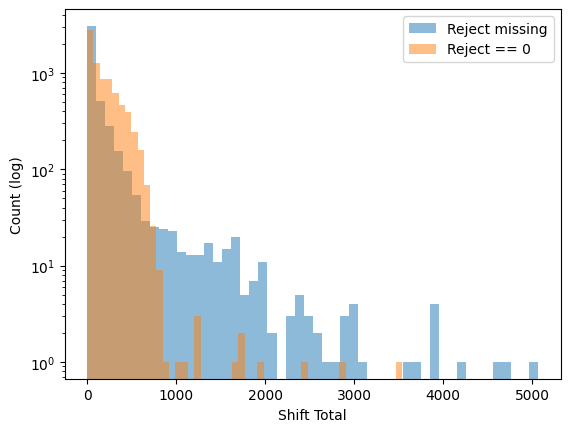

In [117]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(x, bins=50, alpha=0.5, label="Reject missing")
plt.hist(y, bins=50, alpha=0.5, label="Reject == 0")
plt.yscale("log")  # helps because values are skewed
plt.xlabel("Shift Total")
plt.ylabel("Count (log)")
plt.legend()
plt.show()

Reject missing has different shape and a much heavier right tail (many large shift totals).

/var/folders/hs/yssk5t3s26b1vyydg4sfg5200000gn/T/ipykernel_41931/2796667199.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([x, y], labels=["Reject missing", "Reject == 0"], showfliers=False)


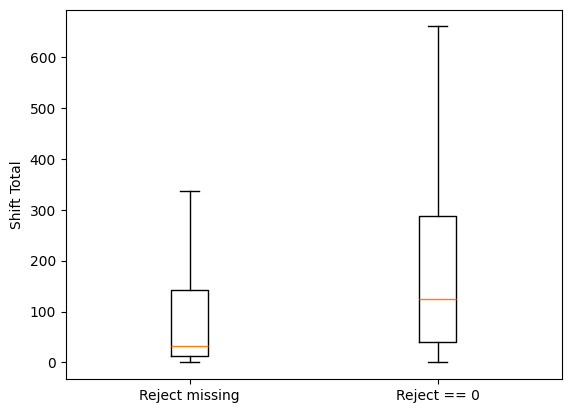

In [121]:
plt.figure()
plt.boxplot([x, y], labels=["Reject missing", "Reject == 0"], showfliers=False)
plt.ylabel("Shift Total")
plt.show()

Vsually, missing and zero groups do not come from the same distribution of production

Mann–Whitney U test:

In [119]:
from scipy.stats import mannwhitneyu

x = df.loc[missing, "Shift Total"].dropna()
y = df.loc[zero, "Shift Total"].dropna()

u = mannwhitneyu(x, y, alternative="two-sided")
u

MannwhitneyuResult(statistic=np.float64(11885956.0), pvalue=np.float64(9.32392518721888e-187))

Are the typical (rank/median-ish) Shift Totals different between the two groups?

p = 9.3e-187

Answer: yes, extremely different.

Kolmogorov–Smirnov (KS) test:

In [120]:
from scipy.stats import ks_2samp

ks = ks_2samp(x, y)
ks

KstestResult(statistic=np.float64(0.30026748888081034), pvalue=np.float64(5.024099956509663e-226), statistic_location=np.float64(47.9), statistic_sign=np.int8(1))

Are the entire distributions different (not only the center)?

A KS statistic of 0.30 means the maximum gap between the two CDFs is 30%

The statistic_location = 47.9 means the largest separation between distributions occurs around Shift Total ≈ 47.9 (kg), which matches the earlier observation that missing is concentrated at small totals.

- Missing values in `Reject Qty` happen even when production exists
- `Reject Qty` missing vs 0 values come from dif. distributions, and therefore cannot be interpreted as zero.

So, missing values in "Reject Qty" is probably “not recorded / unknown”, not “0”.

**Modeling decision:**  
Rows with missing `Reject Qty` are removed from the modeling dataset. This avoids introducing artificial certainty and preserves the integrity of the target variable.

In [128]:
df_model = df[df["Reject Qty"].notna()].copy()

In [130]:
summary = pd.DataFrame({
    "dtype": df_model.dtypes,
    "nulls": df_model.isna().sum(),
    "null_%": (df_model.isna().mean() * 100).round(2),
    "unique": df_model.nunique(dropna=True),
}).sort_values(["nulls", "unique"], ascending=[False, True])

summary

,dtype,nulls,null_%,unique
yarn_count_tex_3,float64,7359,90.67,12
stitch_3,float64,7205,88.78,28
yarn_count_tex_2,float64,4870,60.00,20
stitch_2,float64,3826,47.14,99
Machine Total,float64,359,4.42,4711
Without Shift(Outbound),float64,48,0.59,1
Lot,str,17,0.21,1301
Booking Type,str,0,0.00,5
Yarn_count_length,int64,0,0.00,5
body_part,str,0,0.00,5


In [ ]:
df_model["Reject Qty"].describe()

count    8116.000000
mean        0.231130
std         1.565911
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        41.000000
Name: Reject Qty, dtype: float64

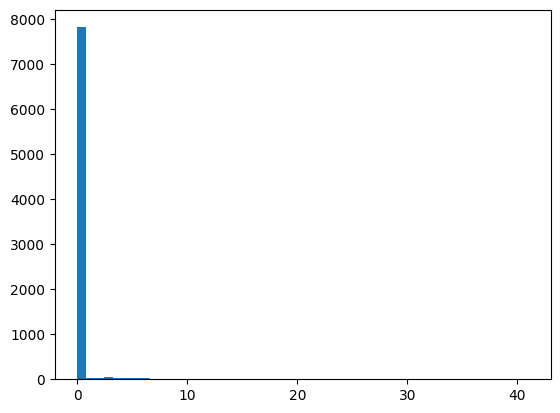

In [132]:
plt.hist(df_model["Reject Qty"], bins=50)
plt.show()

### Decision to wether transform Y

Does Y `Reject Qty` depends on production qty?

In [133]:
cols = ["Reject Qty", "SHIFT-A", "SHIFT-B", "SHIFT-C"]
df_model[cols].describe()

,Reject Qty,SHIFT-A,SHIFT-B,SHIFT-C
count,8116.000000,8116.000000,8116.000000,8116.000000
mean,0.231130,64.995079,61.268578,59.357259
std,1.565911,99.765596,64.497341,63.839133
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.010000,0.010000,0.000000
50%,0.000000,40.200000,36.000000,31.800000
75%,0.000000,102.600000,102.925000,102.000000
max,41.000000,3542.300000,404.200000,389.000000


<Axes: xlabel='SHIFT-A', ylabel='Reject Qty'>

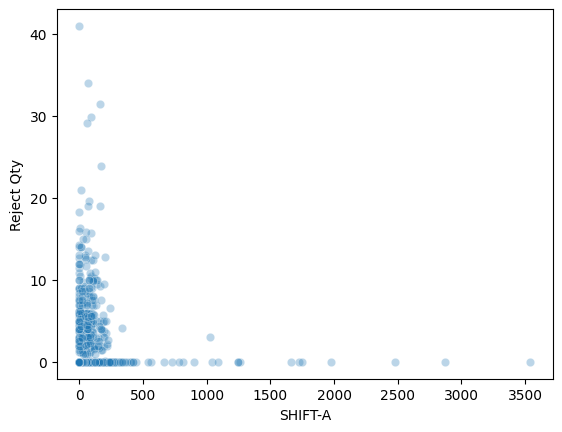

In [135]:
import seaborn as sns
sns.scatterplot(
    data=df_model,
    x="SHIFT-A",
    y="Reject Qty",
    alpha=0.3
)

<Axes: xlabel='SHIFT-B', ylabel='Reject Qty'>

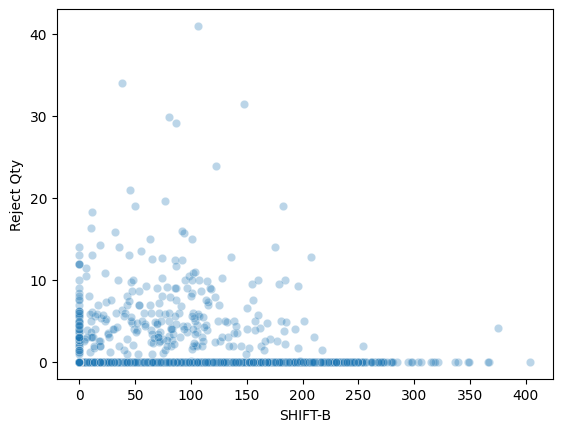

In [136]:
sns.scatterplot(
    data=df_model,
    x="SHIFT-B",
    y="Reject Qty",
    alpha=0.3
)

Very high SHIFT-A does NOT imply high Reject Qty. No linear relationship. We will keep Shifts as X, not as transformations of Y.

Target Y = Reject Qty (kg)

Y values are mostly OK, sometimes very bad 

## 1.6 Verify co-occurence in data

### When `stitch` is present, is `stitch_1` also present?

In [144]:
df_check = df_model

cols_to_check = [
    "stitch", "stitch_1", "stitch_2", "stitch_3",
    "Yarn_Count", "yarn_count_1",
    "yarn_count_tex_1", "yarn_count_tex_2", "yarn_count_tex_3"
]

[c for c in cols_to_check if c in df_check.columns]

['stitch',
 'stitch_1',
 'stitch_2',
 'stitch_3',
 'Yarn_Count',
 'yarn_count_1',
 'yarn_count_tex_1',
 'yarn_count_tex_2',
 'yarn_count_tex_3']

In [154]:
df_check[cols_to_check]

,stitch,stitch_1,stitch_2,stitch_3,Yarn_Count,yarn_count_1,yarn_count_tex_1,yarn_count_tex_2,yarn_count_tex_3
0,4.75,4.75,NaN,NaN,24/1,24/1,24.608333,NaN,NaN
1,4.75,4.75,NaN,NaN,24/1,24/1,24.608333,NaN,NaN
2,4.75,4.75,NaN,NaN,24/1,24/1,24.608333,NaN,NaN
3,4.70,4.70,NaN,NaN,24/1,24/1,24.608333,NaN,NaN
4,4.70,4.70,NaN,NaN,24/1,24/1,24.608333,NaN,NaN
...,...,...,...,...,...,...,...,...,...
12558,4.75/3.15/2.20,4.75,3.15,2.20,"28/1,75D/36F,12/1",28/1,21.092857,8.333333,49.216667
12559,4.75/3.15/2.20,4.75,3.15,2.20,"28/1,75D/36F,12/1",28/1,21.092857,8.333333,49.216667
12560,4.80/3.15/1.66,4.80,3.15,1.66,"30/1,75D/36F,12/1",30/1,19.686667,8.333333,49.216667
12561,4.80/3.15/1.66,4.80,3.15,1.66,"30/1,75D/36F,12/1",30/1,19.686667,8.333333,49.216667


Answer: "stitch_1", "stitch_2", "stitch_3" do come from "stitch"


### Do `stich_2` and `yarn_count_2` show up together?
Do `stitch_3` and `yarn_count_3` show up toether?

In [157]:
pairs = [
    ("stitch_2", "yarn_count_tex_2"),   # or yarn_count_2 if that's your column name
    ("stitch_3", "yarn_count_tex_3"),
]

for s, y in pairs:
    if s not in df_check.columns or y not in df_check.columns:
        print(f"Missing columns for pair: {s}, {y}")
        continue

    both = df_check[s].notna() & df_check[y].notna()
    only_s = df_check[s].notna() & df_check[y].isna()
    only_y = df_check[s].isna() & df_check[y].notna()
    neither = df_check[s].isna() & df_check[y].isna()

    print(f"\nPair: {s} <-> {y}")
    print("  both present :", both.sum())
    print("  only stitch  :", only_s.sum())
    print("  only yarn    :", only_y.sum())
    print("  neither      :", neither.sum())

    # % together among rows where at least one exists
    at_least_one = (df_check[s].notna() | df_check[y].notna())
    pct_together = both.sum() / at_least_one.sum() * 100 if at_least_one.sum() else 0
    print(f"  % together (given at least one exists): {pct_together:.2f}%")


Pair: stitch_2 <-> yarn_count_tex_2
  both present : 3235
  only stitch  : 1055
  only yarn    : 11
  neither      : 3815
  % together (given at least one exists): 75.22%

Pair: stitch_3 <-> yarn_count_tex_3
  both present : 744
  only stitch  : 167
  only yarn    : 13
  neither      : 7192
  % together (given at least one exists): 80.52%


In [159]:
s, y = "stitch_2", "yarn_count_tex_2"
bad = df_check[s].notna() ^ df_check[y].notna()   # XOR: one present, the other missing
df_check.loc[bad, [s, y, "yarn_count_tex_1", "stitch", "Yarn_Count", ]].head(30)

,stitch_2,yarn_count_tex_2,yarn_count_tex_1,stitch,Yarn_Count
19,1.38,NaN,24.608333,2.90/1.38,24/1
20,1.38,NaN,24.608333,2.90/1.38,24/1
21,2.60,NaN,14.765000,2.65/2.60,40/1
48,2.60,NaN,24.608333,2.70/2.60,24/1
49,2.60,NaN,24.608333,2.70/2.60,24/1
57,13.00,NaN,8.333333,12.00/13.00,75D/72F
58,13.00,NaN,8.333333,12.00/13.00,75D/72F
64,1.38,NaN,24.608333,2.90/1.38,24/1
65,1.38,NaN,24.608333,2.90/1.38,24/1
69,1.38,NaN,24.608333,2.90/1.38,24/1


Answer: Not fully.

Missing values in `stitch_2`, `stitch_3`, `yarn_count_text_2` and `yarn_count_text_3` represent inexistence of loop.

**Modeling decision**: 

Create `has_loop_*` and `yarn_count_tex_*` as loop existence flags (structural missingness)


In [160]:
# Stitch loop existence flags (structural missingness)
df_model["has_loop_1"] = df_model["stitch_1"].notna().astype(int) #it should always exist, but safer
df_model["has_loop_2"] = df_model["stitch_2"].notna().astype(int)
df_model["has_loop_3"] = df_model["stitch_3"].notna().astype(int)

# Yarn loop existence flags (use tex columns because they are numeric and cleaner)
df_model["has_yarn_loop_2"] = df_model["yarn_count_tex_2"].notna().astype(int)
df_model["has_yarn_loop_3"] = df_model["yarn_count_tex_3"].notna().astype(int)

## 1.7 Check redundancy: Dia, fabric_dia_1, fabric_dia_2 and M/C Dia & Gauge

They have no missing values, what are the differences between them?

In [163]:
cols = ["Dia", "fabric_dia_1", "fabric_dia_2"]

for col in cols:
    vc = df_model[col].value_counts(dropna=False)
    weird = vc[~vc.index.astype(str).str.match(r"^\d+(\.\d+)?$")]  # not a plain number
    print(f"\n--- {col} ---")
    print("Top values:")
    print(vc.head(15))
    print("\nNon-numeric / mixed values (top 20):")
    print(weird.head(20))


--- Dia ---
Top values:
Dia
72     1319
60     1054
70      881
76      858
68      671
74      553
66      543
56      379
64      359
52      308
78      305
80      182
62      158
54      128
any      88
Name: count, dtype: int64

Non-numeric / mixed values (top 20):
Dia
any      88
66/68    25
83,85    19
70/72    15
68/70     5
62/64     3
52,56     2
74,78     2
68,72     1
64,68     1
52,54     1
Name: count, dtype: int64

--- fabric_dia_1 ---
Top values:
fabric_dia_1
72     1319
60     1054
70      896
76      858
68      677
66      568
74      555
56      379
64      360
52      311
78      305
80      182
62      161
54      128
any      88
Name: count, dtype: int64

Non-numeric / mixed values (top 20):
fabric_dia_1
any    88
Name: count, dtype: int64

--- fabric_dia_2 ---
Top values:
fabric_dia_2
72     1335
60     1054
70      886
76      858
68      697
74      553
66      543
56      381
64      362
52      308
78      307
80      182
62      158
54      129
any      8

In [ ]:
#Build numeric versions of the three columns

import re

df_check = df_model.copy()

# clean strings
for c in ["Dia", "fabric_dia_1", "fabric_dia_2"]:
    df_check[c] = df_check[c].astype(str).str.strip().replace({"any": np.nan, "nan": np.nan, "": np.nan})

# numeric versions for fabric dia columns (these should convert nicely)
df_check["fd1"] = pd.to_numeric(df_check["fabric_dia_1"], errors="coerce")
df_check["fd2"] = pd.to_numeric(df_check["fabric_dia_2"], errors="coerce")

In [166]:
#Dia into up to two numbers
def extract_nums(x):
    if pd.isna(x):
        return []
    nums = re.findall(r"\d+\.?\d*", str(x))
    return [float(n) for n in nums]

dia_nums = df_check["Dia"].apply(extract_nums)
df_check["dia_n"] = dia_nums.apply(len)
df_check["dia_1"] = dia_nums.apply(lambda lst: lst[0] if len(lst) > 0 else np.nan)
df_check["dia_2"] = dia_nums.apply(lambda lst: lst[1] if len(lst) > 1 else np.nan)

In [168]:
m1 = (df_check["dia_n"] == 1) & df_check["fd1"].notna() & df_check["fd2"].notna()

single_ok = np.isclose(df_check.loc[m1, "dia_1"], df_check.loc[m1, "fd1"]) & np.isclose(df_check.loc[m1, "dia_1"], df_check.loc[m1, "fd2"])

print("Single-value Dia rows tested:", m1.sum())
print("Single-value rule match rate:", single_ok.mean())

Single-value Dia rows tested: 7954
Single-value rule match rate: 1.0


So, when `Dia` has one number, both `fabric_dia_1` and `fabric_dia_2` equal that same number.

In [173]:
# Check if when Dia was 2 values (66/68, 83,85, etc) the other two rows match
m2 = (df_check["dia_n"] == 2) & df_check["fd1"].notna() & df_check["fd2"].notna()

set_match_full = pd.Series(False, index=df_check.index)

set_match_full.loc[m2] = (
    (np.isclose(df_check.loc[m2, "fd1"], df_check.loc[m2, "dia_1"]) & np.isclose(df_check.loc[m2, "fd2"], df_check.loc[m2, "dia_2"]))
)

print("Two-value Dia rows tested:", m2.sum())
print("Two-value rule match rate:", set_match_full.loc[m2].mean())

df_check.loc[m2 & ~set_match_full, ["Dia", "fabric_dia_1", "fabric_dia_2"]].head(50)

Two-value Dia rows tested: 74
Two-value rule match rate: 1.0


,Dia,fabric_dia_1,fabric_dia_2


So, when `Dia` has 2 numbers, `fabric_dia_1` and `fabric_dia_2` are exactly the two numbers contained in `Dia`. 

In the same way, `M/C Dia & Gauge` is a string concatenating `m/c_dia` and `m/c_gauge`

### Transition to modeling
At this stage:
- The target variable is well-defined
- Missingness has been interpreted correctly
- Redundant and ambiguous fields have been removed

The next step is to construct a **model-ready dataset** that reflects both:
- controllable process parameters (machine, setup)
- non-controllable context (fabric design, order characteristics)

This distinction is essential for decision-oriented analysis.

# 2. Model

## 2.1 Feature definition & modeling dataset

In this section, the cleaned dataset is transformed into a **model-ready representation**. Feature choices are guided not only by statistical considerations, but also by **process logic** and **decision relevance**.

In particular, variables are grouped according to whether they represent:
- **Controllable process levers** (machine setup, operational parameters)
- **Non-controllable context** (fabric design, order characteristics)

This distinction is central to interpreting model results and translating them into actionable insights.

### Variables to exclude, transform and hold

Exclude:
* "Shift Total": Already proven that is equal to SHIFT-A + SHIFT-B + SHIFT B (Redundant variable)
* "Without Shift (Outbound)": Mostly 0 or NaN, no variance -> no signal
* "stitch": already included in "stitch_1", "stitch_2", "stitch_3"
* "Production Date_raw": already formated in "Production Date"
* "Machine Total" (misaligned granularity, meaning is uncertain)
* "M/C Dia & Gauge": string concatenating "m/c_dia" and m/"c_gauge"
* "Dia": if it has 1 value, is contained in both "fabric_dia_1" and "fabric_dia_2". Id "Dia" has 2 values, its contained in "fabric_dia_1" and "fabric_dia_2" in order.

Transformed variables:
* stitch_1, stitch_3, stitch_3                          --> has_loop_*
* yarn_count_tex_1, yarn_count_tex_2, yarn_count_tex_3  --> has_yarn_loop_*

Hold for now as they are "consequence" variables
* contraction, contraction_1, contraction_2
* fabric_dia_*
* Dia
* GSM

Hold for now (high cardinality)
* Color
* stitch_1, stitch_3, stitch_3, yarn_count_tex_1, yarn_count_tex_2, yarn_count_tex_3

Hold for mixed models later
* Lot

In [161]:
summary = pd.DataFrame({
    "dtype": df_model.dtypes,
    "nulls": df_model.isna().sum(),
    "null_%": (df_model.isna().mean() * 100).round(2),
    "unique": df_model.nunique(dropna=True),
}).sort_values(["nulls", "unique"], ascending=[False, True])

summary

,dtype,nulls,null_%,unique
yarn_count_tex_3,float64,7359,90.67,12
stitch_3,float64,7205,88.78,28
yarn_count_tex_2,float64,4870,60.00,20
stitch_2,float64,3826,47.14,99
Machine Total,float64,359,4.42,4711
Without Shift(Outbound),float64,48,0.59,1
Lot,str,17,0.21,1301
has_loop_1,int64,0,0.00,1
has_loop_2,int64,0,0.00,2
has_loop_3,int64,0,0.00,2


### Final definition of model dataframe (df_model_v1)

🎯 **TARGET**

Y = "Reject Qty" (in kg)

**CONTROLLABLE X (process levers)**

Controllable variables are parameters that can be adjusted or optimized during production, such as:

🏭 Machine / setup

* M/C Brand

* m/c_dia

* m/c_gauge

* number_of_feeders

* tightness_factor

🧶 Yarn / stitch (numeric + structural)

* stitch_1
* stitch_2
* stitch_3
* has_loop_2
* has_loop_3

* yarn_count_tex_1
* yarn_count_tex_2
* yarn_count_tex_3
* has_yarn_loop_2
* has_yarn_loop_3

* Yarn_count_length

👷Operations (context but controllable at management level)

* SHIFT-A

* SHIFT-B

* SHIFT-C

**NON-CONTROLLAEBLE X (demand-driven)**

Non-controllable variables describe the **product or order context**, which is typically fixed by customer requirements, including:

* Booking Type

* body_part

* composition

* construction

* Color Range

* Production Date


In [174]:
# Drop redundant / unusable / high-cardinality string encodings
cols_drop_now = [
    "Index",
    "Shift Total",                 # redundant (A+B+C)
    "Without Shift(Outbound)",      # mostly 0/NaN
    "Production Date_raw",          # duplicate of Production Date
    "Machine Total",                # misaligned granularity / many zeros
    "M/C Dia & Gauge",              # redundant with m/c_dia + m/c_gauge
    "Dia",                          # redundant with fabric_dia_1/2, plus messy
    "stitch",                       # string-encoded loop values
    "Yarn_Count",                   # high cardinality string
    "yarn_count_1",                 # string / high cardinality
    "has_loop_1",                   # constant 1 (no signal) if present
    # We intentionally exclude Color in v1:
    "Color",
]
df_model = df_model.drop(columns=cols_drop_now, errors="ignore")

# Define the final column set for v1
cols_keep_v1 = [
    # Target
    "Reject Qty",

    # Machine/setup (controllable)
    "M/C Brand", "m/c_dia", "m/c_gauge", "number_of_feeders", "tightness_factor",

    # Stitch (numeric + structural)
    "stitch_1", "stitch_2", "stitch_3", "has_loop_2", "has_loop_3",

    # Yarn (tex + structural)
    "yarn_count_tex_1", "yarn_count_tex_2", "yarn_count_tex_3",
    "has_yarn_loop_2", "has_yarn_loop_3",
    "Yarn_count_length",

    # Operations (context, but controllable-ish)
    "SHIFT-A", "SHIFT-B", "SHIFT-C",

    # Non-controllable context (demand-driven)
    "Booking Type", "body_part", "composition", "construction", "Color Range",

    # Time context
    "Production Date",
]

df_model_v1 = df_model[cols_keep_v1].copy()

In [175]:
# quick check
print(df_model_v1.shape)
print(df_model_v1.isna().mean().sort_values(ascending=False).head(10))

(8116, 26)
yarn_count_tex_3    0.906727
stitch_3            0.887753
yarn_count_tex_2    0.600049
stitch_2            0.471414
has_yarn_loop_3     0.000000
Color Range         0.000000
construction        0.000000
composition         0.000000
body_part           0.000000
Booking Type        0.000000
dtype: float64


In [176]:
summary = pd.DataFrame({
    "dtype": df_model_v1.dtypes,
    "nulls": df_model_v1.isna().sum(),
    "null_%": (df_model_v1.isna().mean() * 100).round(2),
    "unique": df_model_v1.nunique(dropna=True),
}).sort_values(["nulls", "unique"], ascending=[False, True])

summary

,dtype,nulls,null_%,unique
yarn_count_tex_3,float64,7359,90.67,12
stitch_3,float64,7205,88.78,28
yarn_count_tex_2,float64,4870,60.00,20
stitch_2,float64,3826,47.14,99
has_loop_2,int64,0,0.00,2
has_loop_3,int64,0,0.00,2
has_yarn_loop_2,int64,0,0.00,2
has_yarn_loop_3,int64,0,0.00,2
Yarn_count_length,int64,0,0.00,5
Booking Type,str,0,0.00,5


## 2.2 Preprocessing for modeling

To prepare the dataset for modeling:
- Categorical variables are one-hot encoded using a reference (baseline) category
- Continuous variables are standardized to improve numerical stability
- Binary indicators are passed through unchanged

No target normalization is applied, as the scale of the response variable (kg of rejects) is meaningful for interpretation and decision-making.

At this stage, preprocessing is intentionally minimal: the goal is to preserve interpretability while ensuring model compatibility.

In [185]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

In [177]:
y = df_model_v1["Reject Qty"].astype(float).values
X_raw = df_model_v1.drop(columns=["Reject Qty"]).copy()

In [181]:
categorical_cols = [
    "M/C Brand",
    "Booking Type",
    "body_part",
    "composition",
    "construction",
    "Color Range",
]

binary_cols = [
    "has_loop_2", "has_loop_3",
    "has_yarn_loop_2", "has_yarn_loop_3",
]

# All remaining are numeric (may include NaNs for structural missingness)
numeric_cols = [c for c in X_raw.columns if c not in categorical_cols + binary_cols]

### Extract simple date features

In [180]:
X_raw["prod_month"] = X_raw["Production Date"].dt.month.astype(int)
X_raw["prod_dayofweek"] = X_raw["Production Date"].dt.dayofweek.astype(int)
X_raw["prod_day_ordinal"] = X_raw["Production Date"].map(pd.Timestamp.toordinal).astype(int)

X_raw = X_raw.drop(columns=["Production Date"])

### One-hot encode low-cardinality categoricals, Scale numeric continuous features, Pass binary as-is

In [186]:
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), categorical_cols),
        ("num", StandardScaler(), numeric_cols),
        ("bin", "passthrough", binary_cols),
    ],
    remainder="drop"
)

# Fit-transform to produce model-ready matrix
X = preprocess.fit_transform(X_raw)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (8116, 63)
y shape: (8116,)


X is now a Numpy array / sparse matrix.

### Transform to dataframe and inspect (sanity check)

In [191]:
# Get feature names from each transformer
cat_features = preprocess.named_transformers_["cat"].get_feature_names_out(categorical_cols)
num_features = np.array(numeric_cols)
bin_features = np.array(binary_cols)

feature_names = np.concatenate([
    cat_features,
    num_features,
    bin_features
])

len(feature_names), feature_names[:10]

(63,
 array(['M/C Brand_Hangxing', 'M/C Brand_Jiunn Long', 'M/C Brand_Lisky',
        'M/C Brand_Pailung', 'M/C Brand_Santoni', 'Booking Type_Other',
        'Booking Type_Partial', 'Booking Type_Sample Without Order',
        'Booking Type_Short', 'body_part_Bottom'], dtype=object))

In [192]:
# Convert X into a DataFrame (so you can see rows)

from scipy import sparse

if sparse.issparse(X):
    X_df = pd.DataFrame.sparse.from_spmatrix(X, columns=feature_names)
else:
    X_df = pd.DataFrame(X, columns=feature_names)

X_df.head()

,M/C Brand_Hangxing,M/C Brand_Jiunn Long,M/C Brand_Lisky,M/C Brand_Pailung,M/C Brand_Santoni,Booking Type_Other,Booking Type_Partial,Booking Type_Sample Without Order,Booking Type_Short,body_part_Bottom,...,SHIFT-A,SHIFT-B,SHIFT-C,prod_month,prod_dayofweek,prod_day_ordinal,has_loop_2,has_loop_3,has_yarn_loop_2,has_yarn_loop_3
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.651518,-0.949998,-0.558270,-1.091675,-0.48537,-1.568805,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.651518,-0.949998,-0.444226,-1.091675,-0.48537,-1.568805,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.651518,-0.949998,-0.464591,-1.091675,-0.48537,-1.568805,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.651518,-0.949998,-0.209246,-1.091675,-0.48537,-1.568805,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.651518,-0.949998,0.335908,-1.091675,-0.48537,-1.568805,0.0,0.0,0.0,0.0


In [195]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)

X_df.sample(1, random_state=42)

,M/C Brand_Hangxing,M/C Brand_Jiunn Long,M/C Brand_Lisky,M/C Brand_Pailung,M/C Brand_Santoni,Booking Type_Other,Booking Type_Partial,Booking Type_Sample Without Order,Booking Type_Short,body_part_Bottom,body_part_Rib,body_part_Top,body_part_other,composition_Cotton_Elastan,composition_Cotton_Polyester,composition_Cotton_Viscose,composition_Polyester,composition_other_cotton_blend,construction_Interlock,construction_LS/J,construction_Mesh,construction_Pique,construction_Rib,construction_S/J,construction_other,Color Range_/AS PER SWATCH,Color Range_Average Color,Color Range_Black Color,Color Range_Dark Color,Color Range_GRAY,Color Range_Light Color,Color Range_MINSTY,Color Range_Medium Color,Color Range_Melange,"Color Range_Melange,Medium Color",Color Range_NAVY,"Color Range_NAVY, QUITE SHADE",Color Range_PVC BLACK,Color Range_QUITE SHADE,Color Range_Wash,Color Range_White Color,"Color Range_White Color,Medium Color",m/c_dia,m/c_gauge,number_of_feeders,tightness_factor,stitch_1,stitch_2,stitch_3,yarn_count_tex_1,yarn_count_tex_2,yarn_count_tex_3,Yarn_count_length,SHIFT-A,SHIFT-B,SHIFT-C,prod_month,prod_dayofweek,prod_day_ordinal,has_loop_2,has_loop_3,has_yarn_loop_2,has_yarn_loop_3
6597,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.544211,0.354669,1.703173,0.440205,-0.397117,NaN,NaN,0.313965,NaN,NaN,-0.744271,1.045564,1.259531,1.6048,1.303576,0.002827,1.072985,0.0,0.0,0.0,0.0


Looks good :)

### For GLM, replacing NaN with 0 

In [199]:
import statsmodels.api as sm

# Structural numeric columns (the ones that had NaNs)
structural_numeric = [
    c for c in X_df.columns
    if ("stitch_" in c or "yarn_count_tex_" in c)
    and not c.startswith("has_")
]

# Replace NaN with 0 ONLY here
X_df[structural_numeric] = X_df[structural_numeric].fillna(0.0)

# Add intercept
X_df = sm.add_constant(X_df, has_constant="add")

In [200]:
X_df.sample(1, random_state=42)

,const,M/C Brand_Hangxing,M/C Brand_Jiunn Long,M/C Brand_Lisky,M/C Brand_Pailung,M/C Brand_Santoni,Booking Type_Other,Booking Type_Partial,Booking Type_Sample Without Order,Booking Type_Short,body_part_Bottom,body_part_Rib,body_part_Top,body_part_other,composition_Cotton_Elastan,composition_Cotton_Polyester,composition_Cotton_Viscose,composition_Polyester,composition_other_cotton_blend,construction_Interlock,construction_LS/J,construction_Mesh,construction_Pique,construction_Rib,construction_S/J,construction_other,Color Range_/AS PER SWATCH,Color Range_Average Color,Color Range_Black Color,Color Range_Dark Color,Color Range_GRAY,Color Range_Light Color,Color Range_MINSTY,Color Range_Medium Color,Color Range_Melange,"Color Range_Melange,Medium Color",Color Range_NAVY,"Color Range_NAVY, QUITE SHADE",Color Range_PVC BLACK,Color Range_QUITE SHADE,Color Range_Wash,Color Range_White Color,"Color Range_White Color,Medium Color",m/c_dia,m/c_gauge,number_of_feeders,tightness_factor,stitch_1,stitch_2,stitch_3,yarn_count_tex_1,yarn_count_tex_2,yarn_count_tex_3,Yarn_count_length,SHIFT-A,SHIFT-B,SHIFT-C,prod_month,prod_dayofweek,prod_day_ordinal,has_loop_2,has_loop_3,has_yarn_loop_2,has_yarn_loop_3
6597,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.544211,0.354669,1.703173,0.440205,-0.397117,0.0,0.0,0.313965,0.0,0.0,-0.744271,1.045564,1.259531,1.6048,1.303576,0.002827,1.072985,0.0,0.0,0.0,0.0


In [209]:
summary = pd.DataFrame({
    "dtype": X_df.dtypes,
    "nulls": X_df.isna().sum(),
    "null_%": (X_df.isna().mean() * 100).round(2),
    "unique": X_df.nunique(dropna=True),
}).sort_values(["nulls", "unique"], ascending=[False, True])

summary

,dtype,nulls,null_%,unique
const,float64,0,0.0,1
M/C Brand_Hangxing,float64,0,0.0,2
M/C Brand_Jiunn Long,float64,0,0.0,2
M/C Brand_Lisky,float64,0,0.0,2
M/C Brand_Pailung,float64,0,0.0,2
...,...,...,...,...
stitch_1,float64,0,0.0,103
tightness_factor,float64,0,0.0,338
SHIFT-C,float64,0,0.0,1887
SHIFT-A,float64,0,0.0,1951


## 2.3 Modeling: GLMs

What we know about Y? Previously we observed:

* continuous (kg)
* 75% zeros
* Values >= 0 (non-negative)
* Long right tail (max = 41 < std)
* Not proportional to productive volume

In [201]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

def evaluate(name, y_true, y_pred):
    print(
        f"{name:12s} | "
        f"MAE={mean_absolute_error(y_true, y_pred):.4f} | "
        f"RMSE={root_mean_squared_error(y_true, y_pred):.4f}"
    )

### 2.3.1. Linear Regression (baseline)

Notes:

* Errors roughly normal + constant variance (often violeded with skew/many zeros)
* Predictions can be negative (bad for our Y)

In [202]:
ols = sm.OLS(y, X_df).fit()
pred_ols = np.clip(ols.predict(X_df), 0, None)

evaluate("OLS", y, pred_ols)

OLS          | MAE=0.4397 | RMSE=1.5489


### 2.3.2. Poisson Regression (count-based GLM)

Notes:

* For counts (nonnegative integers) (Y is >=0 ok, but continous)
* Variance is more or less the mean (here we got overdispersion)

In [203]:
poisson = sm.GLM(y, X_df, family=sm.families.Poisson()).fit()
pred_pois = poisson.predict(X_df)

evaluate("Poisson", y, pred_pois)

Poisson      | MAE=1.0134 | RMSE=1.7103


### 2.3.3. Negative Binomial regression (count-based GLM)

Notes:

* For counts with overdispersion (better than Poisson) but still not perfect for kg

In [204]:
nb = sm.GLM(y, X_df, family=sm.families.NegativeBinomial()).fit()
pred_nb = nb.predict(X_df)

evaluate("NegBin", y, pred_nb)

NegBin       | MAE=0.4292 | RMSE=1.5478


/Users/jimenatagle/Documents/1. Education/4. Personal projects/thread_breaks/.venv/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


### 2.3.4. Gamma regression (continuous GLM)

Notes:

* For continous **positive** outcomes (our data has mainly zeros)
* Right-skewed (ok)

In [205]:
mask_pos = y > 0
X_pos = X_df.loc[mask_pos]
y_pos = y[mask_pos]

gamma = sm.GLM(
    y_pos,
    X_pos,
    family=sm.families.Gamma(sm.families.links.log())
).fit()

pred_gam = gamma.predict(X_pos)
evaluate("Gamma(y>0)", y_pos, pred_gam)

Gamma(y>0)   | MAE=3.3824 | RMSE=5.0906


/Users/jimenatagle/Documents/1. Education/4. Personal projects/thread_breaks/.venv/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [263]:
n_pos = mask_pos.sum()
n_total = len(y)

print("Rows with y > 0:", n_pos)
print("Total rows:", n_total)
print("Percent y > 0:", n_pos / n_total * 100)

Rows with y > 0: 298
Total rows: 8116
Percent y > 0: 3.671759487432233


### 2.3.5. Tweedie regression (GLM Tweedie, 1 < p < 2)

Notes:

* For many zero values (ok)
* For positive continuous values (ok)
* Compound Poisson-Gamma behavior: sometimes zero / otherwise positive continous (ok)

In [210]:
print("Any NaNs in X_df?", np.isnan(X_df.to_numpy()).any())
print("Any infs in X_df?", np.isinf(X_df.to_numpy()).any())

Any NaNs in X_df? False
Any infs in X_df? False


In [215]:
from sklearn.linear_model import TweedieRegressor

powers = [1.1, 1.3, 1.5, 1.7, 1.9]
alphas = [1e-6, 1e-4, 1e-2, 1e-1, 1.0]  # regularization strength

best = None

for p in powers:
    for a in alphas:
        model = TweedieRegressor(power=p, link="log", alpha=a, max_iter=5000)
        model.fit(X_df, y)
        pred = model.predict(X_df)

        rmse_val = root_mean_squared_error(y, pred)
        if best is None or rmse_val < best["rmse"]:
            best = {"p": p, "alpha": a, "model": model, "rmse": rmse_val}

        # Optional: print a small grid
        print(f"Tweedie(p={p:.1f}, alpha={a:g}) RMSE={rmse_val:.4f}")

print("\nBest Tweedie:", best["p"], "alpha=", best["alpha"], "RMSE=", best["rmse"])
evaluate(f"Tweedie(p={best['p']}, a={best['alpha']})", y, best["model"].predict(X_df))

Tweedie(p=1.1, alpha=1e-06) RMSE=1.5460
Tweedie(p=1.1, alpha=0.0001) RMSE=1.5458
Tweedie(p=1.1, alpha=0.01) RMSE=1.5484
Tweedie(p=1.1, alpha=0.1) RMSE=1.5540
Tweedie(p=1.1, alpha=1) RMSE=1.5615
Tweedie(p=1.3, alpha=1e-06) RMSE=1.5477
Tweedie(p=1.3, alpha=0.0001) RMSE=1.5473
Tweedie(p=1.3, alpha=0.01) RMSE=1.5489
Tweedie(p=1.3, alpha=0.1) RMSE=1.5537
Tweedie(p=1.3, alpha=1) RMSE=1.5607
Tweedie(p=1.5, alpha=1e-06) RMSE=1.5519
Tweedie(p=1.5, alpha=0.0001) RMSE=1.5500
Tweedie(p=1.5, alpha=0.01) RMSE=1.5498
Tweedie(p=1.5, alpha=0.1) RMSE=1.5537
Tweedie(p=1.5, alpha=1) RMSE=1.5600
Tweedie(p=1.7, alpha=1e-06) RMSE=1.5614
Tweedie(p=1.7, alpha=0.0001) RMSE=1.5587
Tweedie(p=1.7, alpha=0.01) RMSE=1.5519
Tweedie(p=1.7, alpha=0.1) RMSE=1.5540
Tweedie(p=1.7, alpha=1) RMSE=1.5593


/Users/jimenatagle/Documents/1. Education/4. Personal projects/thread_breaks/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/jimenatagle/Documents/1. Education/4. Personal projects/thread_breaks/.venv/lib/python3.12/site-packages/sklearn/linear_model/_glm/glm.py:290: ConvergenceWarning: lbfgs failed to converge after 302 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result(
/Users/jimenatagle/Documents/1. Education/4. Personal projects/thread_breaks/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/jimenatagle/Documents/1. Education/4. Personal projects/thread_breaks/.venv/lib/pyth

Tweedie(p=1.9, alpha=1e-06) RMSE=1.7220
Tweedie(p=1.9, alpha=0.0001) RMSE=1.7629
Tweedie(p=1.9, alpha=0.01) RMSE=1.5683
Tweedie(p=1.9, alpha=0.1) RMSE=1.5557
Tweedie(p=1.9, alpha=1) RMSE=1.5588

Best Tweedie: 1.1 alpha= 0.0001 RMSE= 1.5458491936174936
Tweedie(p=1.1, a=0.0001) | MAE=0.4288 | RMSE=1.5458


Single train/test split to validate good generalization.

In [216]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_df, y, test_size=0.2, random_state=42
)

model = TweedieRegressor(power=1.1, link="log", alpha=1e-4, max_iter=5000)
model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_test  = model.predict(X_test)

evaluate("Tweedie - train", y_train, pred_train)
evaluate("Tweedie - test ", y_test,  pred_test)

Tweedie - train | MAE=0.4553 | RMSE=1.6237
Tweedie - test  | MAE=0.3837 | RMSE=1.1881


a couple examples:

In [217]:
# Build comparison df
cmp = pd.DataFrame({
    "y_true": y_test,
    "y_pred": pred_test,
    "abs_error": np.abs(y_test - pred_test)
})

# Random 10 rows
cmp.sample(10, random_state=42)

,y_true,y_pred,abs_error
135,0.0,0.442278,0.442278
481,0.0,0.005230,0.005230
836,0.0,0.007017,0.007017
1226,0.0,1.142254,1.142254
629,0.0,0.049072,0.049072
1168,0.0,0.202015,0.202015
1593,0.0,0.002889,0.002889
816,0.0,0.368106,0.368106
926,0.0,0.115560,0.115560
271,0.0,1.047268,1.047268


In [218]:
cmp.sort_values("abs_error", ascending=False).head(10)

,y_true,y_pred,abs_error
39,16.4,0.164569,16.235431
1115,15.9,0.607973,15.292027
254,14.0,0.015547,13.984453
1366,13.0,0.076047,12.923953
853,13.0,0.148636,12.851364
33,11.7,0.586895,11.113105
1460,11.0,0.090793,10.909207
1403,10.0,0.667750,9.332250
1402,10.0,1.219497,8.780503
1384,8.7,0.362753,8.337247


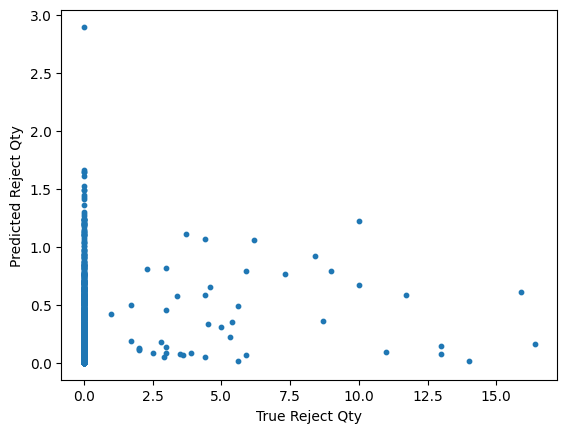

In [219]:
import matplotlib.pyplot as plt

plt.scatter(cmp["y_true"], cmp["y_pred"], s=10)
plt.xlabel("True Reject Qty")
plt.ylabel("Predicted Reject Qty")
plt.show()

In [220]:
y_arr = np.asarray(y_test)

for thr in [0, 1, 5, 10]:
    print(thr, (y_arr > thr).mean(), "fraction of test > thr")

0 0.02770935960591133 fraction of test > thr
1 0.027093596059113302 fraction of test > thr
5 0.012315270935960592 fraction of test > thr
10 0.004310344827586207 fraction of test > thr


Big rejection quantities are too rare.

### Interim conclusions: GLM comparison

Several generalized linear models were evaluated to assess their suitability for modeling textile reject quantities. While linear regression provides a useful baseline, its assumptions (normal errors, constant variance, unrestricted predictions) are not compatible with a zero-heavy, right-skewed response variable.

Count-based models (Poisson and Negative Binomial) improve on linear regression by enforcing non-negativity, but remain conceptually misaligned with the target, which represents a **continuous quantity in kilograms rather than discrete counts**. As expected, Poisson regression performs poorly due to strong overdispersion, while Negative Binomial offers only marginal improvement.

Gamma regression, applied only to positive outcomes, highlights that **reject severity alone cannot be modeled independently of reject occurrence**. This reinforces the idea that different mechanisms govern whether a defect happens and how severe it becomes.

Among single-stage models, the Tweedie GLM provides the most appropriate formulation. It naturally accommodates a mixture of zeros and positive continuous values and exhibits stable train–test performance. Although absolute error metrics remain non-negligible relative to the mean, this is expected given the heavy-tailed nature of the data and the dominance of zero observations.

These results motivate a modeling strategy that explicitly separates **defect occurrence** from **defect severity**, which is explored in the next section.

## 2.5 Models: two-stage model

### Motivation

Previous results show that fabric rejects are **rare events**: only a small fraction of production records exhibit nonzero reject quantities. Moreover, the factors that influence **whether a reject occurs** are not necessarily the same as those that determine **how severe it becomes**.

Modeling these two mechanisms with a single equation forces incompatible assumptions and leads to unstable estimates. To address this, a two-stage (hurdle) modeling strategy is adopted:

1. **Stage 1** models the probability that any reject occurs (has / has not rejects)
2. **Stage 2** models the severity of the reject, conditional on occurrence   (severity on positives only)

This separation aligns naturally with industrial decision-making, where prevention and damage containment require different actions.

In [221]:
# 1. Logistic regression for any reject
from sklearn.linear_model import LogisticRegression

z_train = (y_train > 0).astype(int)
z_test  = (y_test > 0).astype(int)

clf = LogisticRegression(max_iter=5000)
clf.fit(X_train, z_train)

p_test = clf.predict_proba(X_test)[:, 1]   # P(y>0)

In [222]:
# 2. Gamma on log scale: severy model on positives only

from sklearn.linear_model import GammaRegressor

mask_pos_train = y_train > 0
mask_pos_test  = y_test > 0

sev = GammaRegressor(alpha=1e-4, max_iter=5000)  # regularized Gamma GLM
sev.fit(X_train[mask_pos_train], y_train[mask_pos_train])

sev_pred_test = sev.predict(X_test)  #we compute every row 

In [223]:
# 3. Combine

yhat_test = p_test * sev_pred_test

evaluate("Two-stage", y_test, yhat_test)

Two-stage    | MAE=0.3860 | RMSE=1.1846


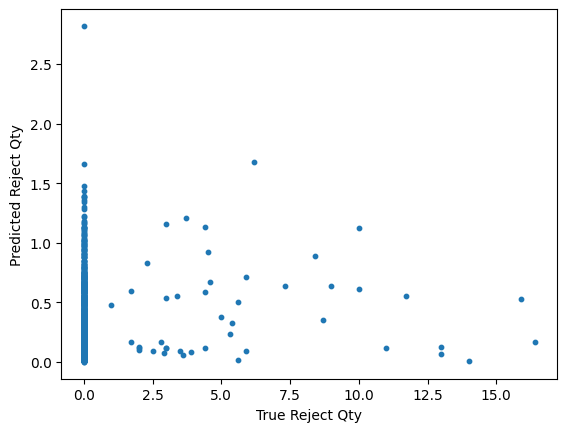

In [224]:
# Build comparison df
cmp = pd.DataFrame({
    "y_true": y_test,
    "y_pred": yhat_test,
    "abs_error": np.abs(y_test - yhat_test)
})

plt.scatter(cmp["y_true"], cmp["y_pred"], s=10)
plt.xlabel("True Reject Qty")
plt.ylabel("Predicted Reject Qty")
plt.show()

### Stage 1 interpretation: what triggers a reject?

In [247]:
# First, check one-hots baselines

ohe = preprocess.named_transformers_["cat"]

for i, col in enumerate(categorical_cols):
    cats = list(ohe.categories_[i])
    baseline = cats[0]  # because drop="first"
    print(f"{col:15s} baseline -> {baseline}")

M/C Brand       baseline -> Fukuhara
Booking Type    baseline -> Main
body_part       baseline -> Body
composition     baseline -> Cotton
construction    baseline -> Fleece_terry
Color Range     baseline -> ,Navy  


In [237]:
coef_stage1 = pd.Series(
    clf.coef_[0],
    index=X_train.columns
)

or_stage1 = np.exp(coef_stage1).sort_values(ascending=False)
print(or_stage1.head(15))

has_loop_2                     2.221214
M/C Brand_Lisky                1.799713
has_yarn_loop_2                1.720651
construction_LS/J              1.410148
has_loop_3                     1.376138
Color Range_Black Color        1.279923
SHIFT-B                        1.241641
Color Range_Wash               1.237249
Color Range_Average Color      1.176924
Color Range_Light Color        1.161771
yarn_count_tex_1               1.143053
construction_Interlock         1.137908
Color Range_Medium Color       1.086816
body_part_Bottom               1.068565
m/c_dia                        1.056206
dtype: float64


In [246]:
coef_stage1_low = pd.Series(
    clf.coef_[0],
    index=X_train.columns
)

or_stage1_low = np.exp(coef_stage1_low).sort_values(ascending=True)
print(or_stage1_low.head(15))

body_part_Rib                        0.294682
composition_other_cotton_blend       0.327316
construction_Mesh                    0.362922
stitch_3                             0.438571
Booking Type_Other                   0.557944
stitch_1                             0.594263
M/C Brand_Santoni                    0.627120
Color Range_Melange                  0.645544
composition_Cotton_Polyester         0.686889
Booking Type_Sample Without Order    0.703648
construction_Rib                     0.743985
construction_Pique                   0.748245
body_part_other                      0.751176
composition_Polyester                0.752012
const                                0.757955
dtype: float64


OR > 1 → increases probability of any reject

OR < 1 → decreases probability

OR = 1 → neutral

Second loop present (has_loop_2)

-> More than doubles the odds of a reject occurring

-> Structural complexity is a major risk trigger

In [ ]:
# These are the controllable ones -> actinable prevention. The others should be managed (not eliminated)
controllable_vars = [
    "m/c_dia", "m/c_gauge", "number_of_feeders", "tightness_factor",
    "has_loop_2", "has_loop_3",
    "has_yarn_loop_2", "has_yarn_loop_3"
]

or_stage1.loc[or_stage1.index.str.contains("|".join(controllable_vars))]

has_loop_2           2.221214
has_yarn_loop_2      1.720651
has_loop_3           1.376138
m/c_dia              1.056206
number_of_feeders    1.000718
has_yarn_loop_3      0.941812
tightness_factor     0.881940
m/c_gauge            0.798648
dtype: float64

#### Interpretation: drivers of reject occurrence

Estimated odds ratios highlight variables that significantly increase or decrease the likelihood of a reject occurring. Structural fabric characteristics (e.g. presence of additional loops) emerge as the strongest predictors, indicating that **design complexity is a primary risk driver**.

Several controllable process parameters (machine setup, operational context) also influence reject probability, though with smaller effect sizes. This distinction helps identify where preventive actions can be most effective.

### Stage 2 interpretation: what drives severity given a reject happened?

In [239]:
# Stage 2 interpreation: 
coef_stage2 = pd.Series(
    sev.coef_,
    index=X_train.columns
)

mult_effect = np.exp(coef_stage2).sort_values(ascending=False)
mult_effect.head(15)

construction_Pique              2.597562
construction_LS/J               1.973212
construction_Interlock          1.957055
construction_S/J                1.942581
composition_Polyester           1.665244
composition_Cotton_Polyester    1.544507
construction_Rib                1.534452
m/c_dia                         1.443787
has_loop_3                      1.357437
Color Range_White Color         1.345774
yarn_count_tex_3                1.288675
yarn_count_tex_1                1.260744
yarn_count_tex_2                1.246442
body_part_other                 1.240689
has_loop_2                      1.199129
dtype: float64

Severity drivers differ from occurrence drivers. **Fabric construction** and **composition** play a dominant role in determining how large losses become once a reject occurs, while some variables that strongly affect occurrence have only modest impact on severity.

This confirms that reject occurrence and severity are governed by **distinct mechanisms**, reinforcing the value of a two-stage modeling strategy.

In [240]:
compare = pd.DataFrame({
    "OR_any_reject": or_stage1,
    "Severity_multiplier": mult_effect
}).dropna()

compare.sort_values("OR_any_reject", ascending=False).head(10)

,OR_any_reject,Severity_multiplier
has_loop_2,2.221214,1.199129
M/C Brand_Lisky,1.799713,0.364153
has_yarn_loop_2,1.720651,0.846799
construction_LS/J,1.410148,1.973212
has_loop_3,1.376138,1.357437
Color Range_Black Color,1.279923,0.908268
SHIFT-B,1.241641,1.085586
Color Range_Wash,1.237249,0.762475
Color Range_Average Color,1.176924,1.054744
Color Range_Light Color,1.161771,0.965224


### Can we detect big loss situations?

In [242]:
threshold = 3

y_big = (y_test > threshold).astype(int)
yhat_big = (yhat_test > threshold).astype(int)

from sklearn.metrics import classification_report

print(classification_report(y_big, yhat_big))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1593
           1       0.00      0.00      0.00        31

    accuracy                           0.98      1624
   macro avg       0.49      0.50      0.50      1624
weighted avg       0.96      0.98      0.97      1624



/Users/jimenatagle/Documents/1. Education/4. Personal projects/thread_breaks/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/jimenatagle/Documents/1. Education/4. Personal projects/thread_breaks/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/jimenatagle/Documents/1. Education/4. Personal projects/thread_breaks/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being se

The model never confidently predicts y > 3 kg. Large losses are not predictable from available X variables alone. Big losses may kiely come from maintenance events, operator errors, transient faults, material defects, etc. none of these in the dataset.

### Combined interpretation

In [243]:
df_cal = pd.DataFrame({
    "y_true": y_test,
    "y_pred": yhat_test
})

df_cal["pred_bin"] = pd.qcut(df_cal["y_pred"], q=10, duplicates="drop")

df_cal.groupby("pred_bin")[["y_true", "y_pred"]].mean()

,y_true,y_pred
pred_bin,,
"(-0.00099999991, 0.0261]",0.120245,0.011825
"(0.0261, 0.0619]",0.022222,0.044185
"(0.0619, 0.0922]",0.174074,0.076395
"(0.0922, 0.12]",0.146626,0.106051
"(0.12, 0.152]",0.123457,0.134678
"(0.152, 0.189]",0.129012,0.170006
"(0.189, 0.249]",0.032515,0.215042
"(0.249, 0.386]",0.117901,0.309272
"(0.386, 0.627]",0.350000,0.510554


Higher predicted bins -> higher actual loss (monotonic trend). Absolute values are low but ranking words:

Top-risk group has about 2.6x higher loss: this proves the model is useful for **priorization**, not exact prediction.

In [244]:
top10 = df_cal.nlargest(int(0.1 * len(df_cal)), "y_pred")

print(
    "Avg actual loss (top 10% risk):",
    top10["y_true"].mean()
)
print(
    "Avg actual loss (overall):",
    df_cal["y_true"].mean()
)

Avg actual loss (top 10% risk): 0.42777777777777776
Avg actual loss (overall): 0.1641625615763547


Conclusions:
* Exact prediction of catastrophic losses is unreliable
* Probabiliy of rejects is partially explaniable
* Severity drivers differ from trigger drivers
* Model is better used for **risk ranking**, not forcasting

So far we tested: GLM, Poisson, Gamma, Tweedie and Two-stage (logistic + gamma) and they all have the same failure mode: large losses are systematically underpredicted. Given the variables you have, the data does not contain enough signal to predict extreme events. This a data limitation, not a modeling one.

For explanitability and Six Sigma, best choises are Tweedie glm and last two-stage GLM: interpretable, coefficients ap to process levers + rank lists (e.g., top 10% risk has 2.6x higher actual loss -> operationally useful, exact kg doesn't matter)

## 2.6 Models: XGBoost to test nonlinear interactions
XGBoost to test whether nonlinear interactions + threshold effects extract more signal from the same X

### Motivation

While generalized linear models offer strong interpretability and stability, they assume additive effects and limited nonlinear interactions. To assess whether additional predictive signal could be extracted from the same feature set, a nonlinear tree-based ensemble model (XGBoost) is used as a benchmark.

The objective of this comparison is not to replace interpretable models, but to answer a specific question:
> *Do nonlinear interactions and threshold effects materially improve predictive performance for this problem?*

### General results

In [249]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",  # plain regression
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

pred_train = xgb_model.predict(X_train)
pred_test  = xgb_model.predict(X_test)

def evaluate(name, y_true, y_pred):
    print(
        f"{name:12s} | "
        f"MAE={mean_absolute_error(y_true, y_pred):.4f} | "
        f"RMSE={root_mean_squared_error(y_true, y_pred):.4f}"
    )

evaluate("XGB train", y_train, pred_train)
evaluate("XGB test ", y_test,  pred_test)

XGB train    | MAE=0.3760 | RMSE=1.1700
XGB test     | MAE=0.4276 | RMSE=1.2677


Train is better than test, but not dramatically (mild overfitting). Test RMSE is worse than Tweedie (~1.19) and Two-stage (~1.18) -> XGBoost does not improve overall predictive accuracy. Flexible nonlinear structure did not extract more signal from the same X.

### Tail behavior analysis

In [ ]:
# Inspect worst errors

cmp_xgb = pd.DataFrame({
    "y_true": y_test,
    "y_pred": pred_test,
    "abs_error": np.abs(y_test - pred_test)
})

cmp_xgb.sort_values("abs_error", ascending=False).head(10)

,y_true,y_pred,abs_error
39,16.4,0.229078,16.170922
1115,15.9,0.667756,15.232244
254,14.0,0.203852,13.796148
1366,13.0,-0.099214,13.099214
853,13.0,0.269054,12.730946
119,0.0,11.701991,11.701991
1460,11.0,0.068344,10.931656
33,11.7,1.808455,9.891545
296,9.0,0.445734,8.554266
1403,10.0,1.760996,8.239004


XGBoost still severely underpredicts extreme losses. It also introduces false positives (predicting large loss when none occurred). This is actually worse than the GLM-based models, which were conservative but stable.

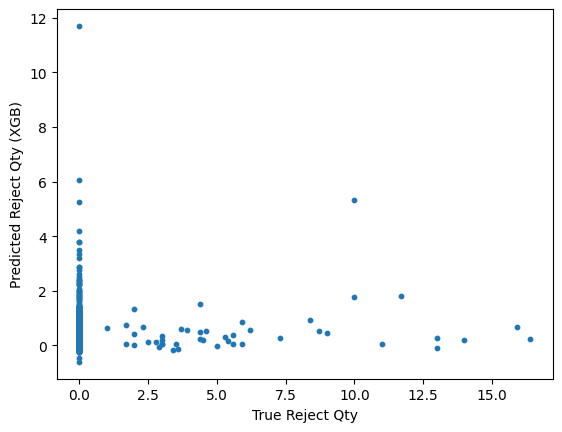

In [251]:
plt.scatter(cmp_xgb["y_true"], cmp_xgb["y_pred"], s=10)
plt.xlabel("True Reject Qty")
plt.ylabel("Predicted Reject Qty (XGB)")
plt.show()

No hidden nonlinear pattern waiting to be unlocked.

In [252]:
threshold = 3

y_big = (y_test > threshold).astype(int)
yhat_big = (pred_test > threshold).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_big, yhat_big))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1593
           1       0.10      0.03      0.05        31

    accuracy                           0.98      1624
   macro avg       0.54      0.51      0.52      1624
weighted avg       0.96      0.98      0.97      1624



### Risk ranking check

In [ ]:
# Risk ranking check

df_cal_xgb = pd.DataFrame({
    "y_true": y_test,
    "y_pred": pred_test
})

df_cal_xgb["pred_bin"] = pd.qcut(df_cal_xgb["y_pred"], q=10, duplicates="drop")

df_cal_xgb.groupby("pred_bin")[["y_true", "y_pred"]].mean()

,y_true,y_pred
pred_bin,,
"(-0.604, -0.0535]",0.122699,-0.102884
"(-0.0535, -0.00646]",0.048765,-0.030358
"(-0.00646, 0.028]",0.012346,0.011297
"(0.028, 0.0625]",0.099387,0.045347
"(0.0625, 0.108]",0.108025,0.083424
"(0.108, 0.17]",0.066049,0.137246
"(0.17, 0.264]",0.304294,0.211522
"(0.264, 0.397]",0.166049,0.325737
"(0.397, 0.675]",0.380864,0.514316


No clean monotonic increase. Ranking is noisy.

In [254]:
top10_xgb = df_cal_xgb.nlargest(int(0.1 * len(df_cal_xgb)), "y_pred")

print("Avg actual loss (top 10% risk, XGB):", top10_xgb["y_true"].mean())
print("Avg actual loss (overall):", df_cal_xgb["y_true"].mean())

Avg actual loss (top 10% risk, XGB): 0.3339506172839506
Avg actual loss (overall): 0.1641625615763547


Risk ratio ia about 2.0x compared to our two-stage model that had 2.6x this one is worst at prioritizing risk, despite being more complex.

### Feature importance considerations

Feature importance scores from XGBoost are based on split frequency and do not provide causal interpretation. While they offer insight into which variables the model relies on, they are less informative than coefficient-based effects from GLMs and are more sensitive to noise and feature cardinality.

For this reason, feature importance results are treated as exploratory rather than explanatory.

In [255]:
# feature improtance

importances = pd.Series(
    xgb_model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

importances.head(15)

M/C Brand_Jiunn Long            0.053372
Color Range_Dark Color          0.049488
composition_Cotton_Elastan      0.048891
body_part_Top                   0.047208
prod_month                      0.044551
composition_Cotton_Polyester    0.043615
Color Range_White Color         0.042479
Color Range_Average Color       0.034572
SHIFT-A                         0.032255
SHIFT-B                         0.031880
number_of_feeders               0.025201
body_part_Bottom                0.024828
yarn_count_tex_2                0.024686
M/C Brand_Hangxing              0.023447
composition_Polyester           0.022586
dtype: float32

### Conclusion of nonlinear benchmarking

The XGBoost benchmark confirms that, for this dataset, increased model complexity does not translate into better generalization or improved detection of extreme quality losses. This reinforces the conclusion that the primary limitation lies in the available information rather than in model capacity.

Given the need for interpretability, stability, and actionable insights, the two-stage probabilistic model remains the preferred approach for this problem.

# 3. Conclusions

## 3.1 Model comparison summary and conclusions



| Model            | Test RMSE ↓ | Tail detection (large rejects) | Risk ranking ability | Interpretability |
|------------------|-------------|--------------------------------|----------------------|------------------|
| Tweedie GLM      | ~1.19       | ❌ None detected               | ✅ Good              | ✅✅ High        |
| Two-stage GLM<br>(Logistic + Gamma) | ~1.18 | ❌ None detected | ✅✅ Very good | ✅✅ High |
| XGBoost Regressor| ~1.27       | ⚠️ Very weak (≈3% recall)      | ⚠️ Moderate          | ❌ Low          |

**Notes:**
- *Tail detection* refers to the ability to identify large reject events (e.g. `Reject Qty > 3 kg`).
- *Risk ranking ability* measures whether high predicted values correspond to higher average actual loss.
- *Interpretability* reflects how directly model outputs can be translated into actionable process insights.

Several modeling approaches were evaluated to predict fabric reject quantities, ranging from interpretable statistical models to flexible nonlinear machine learning methods. While tree-based models such as XGBoost were able to capture limited nonlinear patterns, they did not improve predictive accuracy on unseen data and performed poorly in identifying extreme reject events. This suggests that catastrophic quality losses are driven by latent factors not captured in the available process and product variables.

In contrast, generalized linear models, particularly the two-stage (logistic + Gamma) formulation, provided stable performance, strong risk-ranking capability, and clear interpretability. Although none of the models were able to accurately predict rare large-loss events, the two-stage model successfully distinguished higher-risk operating conditions and highlighted actionable process and design drivers influencing both reject occurrence and severity.

Overall, the results indicate that the primary value of modeling in this context lies not in precise loss prediction, but in **risk identification, process understanding, and decision support**. The two-stage GLM therefore represents the most appropriate modeling choice for guiding quality improvement and control efforts in an industrial textile setting.

## 3.2 Practical insights and actionable drivers conclusions

Beyond model selection, the two-stage GLM enables a clear interpretation of **which factors increase quality risk and by how much**:

**Key drivers of reject occurrence**
- Presence of a second fabric loop: ~2.2x increase of rejection odds
- Presence of additional yarn loops: ~1.7 increase of rejection odds
- Certain machine characteristics (diameter, brand) are associated with moderately higher reject probability

**Key drivers of reject severity**
- Fabric construction types (Pique, LS/J, Interlock): losses ~1.9× to 2.6× larger than baseline (Fleece_terry)
- Material composition (Polyester and blends): losses ~1.5×–1.7 higher than baseline (Cotton)
- Larger machine diameter 

**Prevention vs containment**

- **Prevention-focused levers**  
  Variables that strongly affect reject probability should be addressed during **fabric design and setup planning**.

- **Containment-focused levers**  
  Variables that mainly affect severity should inform **monitoring intensity, inspection frequency, and control limits**.

This distinction allows production teams to focus preventive effort where failures are most likely, and mitigation effort where failures are most costly.

